# Basic characterizations of LA Q3
### using Experiment and Analysis classes

In [118]:
from qm.qua import *
from qm import QuantumMachinesManager, SimulationConfig, LoopbackInterface, generate_qua_script
from qm.octave import *
from qm.octave.octave_manager import ClockMode
from configuration import *
from scipy import signal
from qualang_tools.bakery import baking
from qualang_tools.units import unit
from qm.octave import QmOctaveConfig
from set_octave import ElementsSettings, octave_settings
from quam import QuAM
from scipy.io import savemat, loadmat
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 6 # for LA Q3
res_index = 6 # for LA Q3
flux_index = 6 # for LA Q3
TLS_index = 0 # for TLS of interest

In [119]:
Experiment = ExperimentHandle()
Analysis = AnalysisHandle()
machine = Analysis.get_machine()

In [120]:
# Set all DC bias to 0
for i in np.arange(7):
    val = machine.flux_lines[i].dc_voltage       
    machine.flux_lines[i].dc_voltage -= val
machine = Analysis.set_machine(machine)

In [121]:
# initialize Labber-controlled hardware
Experiment.set_Labber(Analysis.get_machine(), qubit_index, res_index, flux_index)
# set octave to external clock
#Experiment.set_external_clock()

In [122]:
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50e6
machine = Analysis.set_machine(machine)

In [123]:
# octave calibration
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True)

2024-04-03 11:56:00,132 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-03 11:56:00,141 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r6 for (LO, IF) = (6.071 GHz, -50.000 MHz)
2024-04-03 11:56:07,908 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q6 for (LO, IF) = (5.442 GHz, -50.000 MHz)
2024-04-03 11:56:21,619 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## Time of flight

DC offset to add to I: -0.051847 V
DC offset to add to Q: -0.064033 V
TOF to add: 8.0 ns


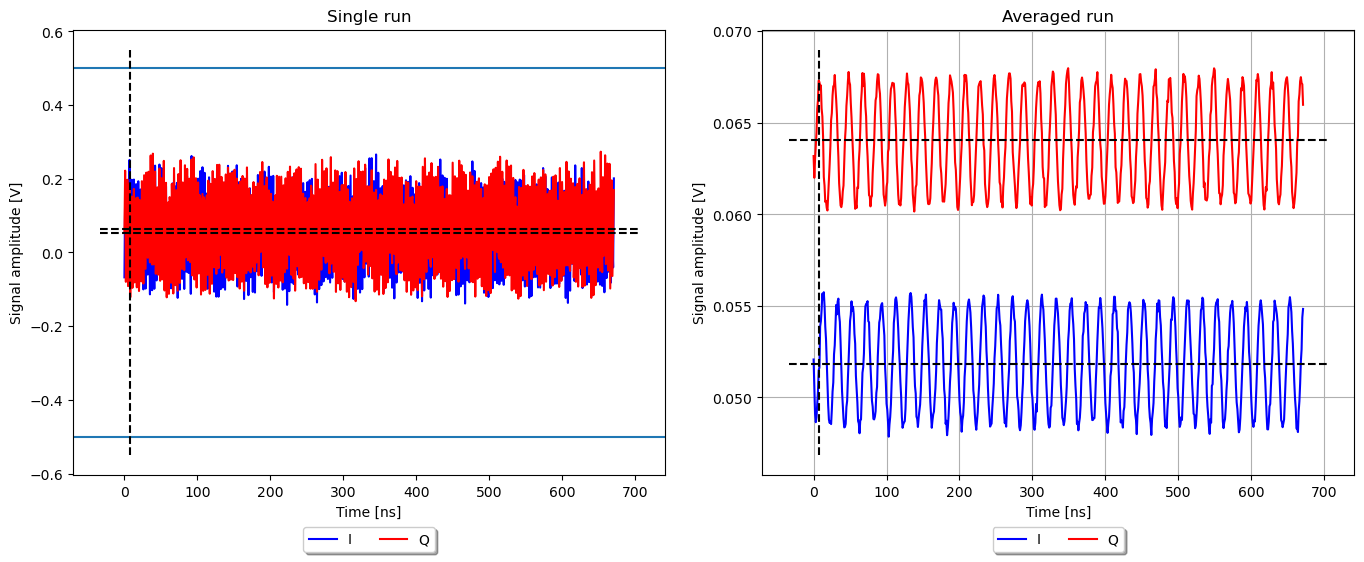

In [124]:
# time_of_flight
# experiment
machine, adc1, adc2, adc1_single, adc2_single = Experiment.exp1D.RR.time_of_flight(qubit_index,res_index,flux_index, n_avg = 10E3, cd_time = 10E3, simulate_flag = False, simulation_len = 1000)
# plot
%matplotlib inline
dc_offset_i, dc_offset_q, delay = Analysis.exp1D.time_of_flight(adc1,adc2,adc1_single,adc2_single)

In [125]:
# update the offset
machine.global_parameters.con1_downconversion_offset_I += dc_offset_i.item()
machine.global_parameters.con1_downconversion_offset_Q += dc_offset_q.item()
#machine.global_parameters.time_of_flight = 304-0
machine = Analysis.set_machine(machine)

## 1D RO resonator spectroscopy

In [220]:
%matplotlib qt
machine = Analysis.get_machine()
res_freq_sweep = machine.resonators[res_index].f_readout + np.arange(-10E6,10E6 + 1.0,0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                            n_avg = 1E3, cd_time = 5E3, readout_state = 'g', simulate_flag = False, simulation_len = 1000)
# Readout in excited state
# machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
#                           n_avg = 1E3, cd_time = 5E3, readout_state = 'e', simulate_flag = False, simulation_len = 1000)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 2.30s


resonator frequency: 6020.769 MHz
Execution stopped by user!


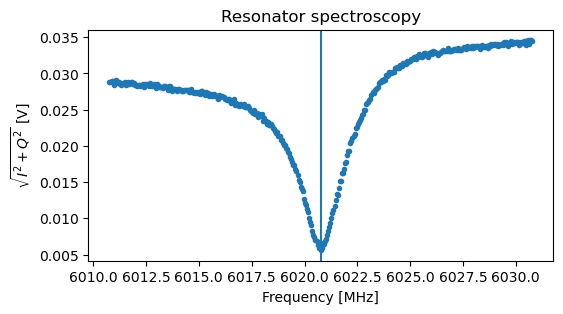

In [221]:
# find the minimal
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
machine.resonators[res_index].f_readout = res_freq.tolist() + 0E6
machine.resonators[res_index].lo = res_freq.tolist() + 50E6
machine = Analysis.set_machine(machine)

In [222]:
# octave calibration
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True)

2024-03-21 09:14:14,462 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-21 09:14:14,472 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r6 for (LO, IF) = (6.071 GHz, -50.000 MHz)
2024-03-21 09:14:22,363 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q6 for (LO, IF) = (5.460 GHz, -50.000 MHz)
2024-03-21 09:14:35,378 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## 2D RO resonator spectroscopy vs DC flux

Progress: [##################################################] 100.0% (n=37/37)


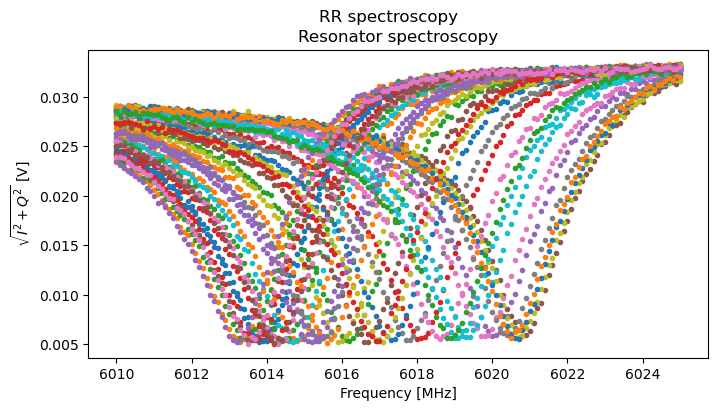

In [223]:
res_freq_sweep = np.arange(6.01E9,6.025E9 + 1.0,0.1E6)
dc_flux_sweep = np.arange(-9,9.001,0.5)
%matplotlib inline
machine, res_freq_sweep, dc_flux_sweep, sig_amp = Experiment.exp2D.RR.rr_vs_dc_flux(res_freq_sweep, dc_flux_sweep, qubit_index, res_index, flux_index, 
                            n_avg = 1E3, cd_time = 10E3)

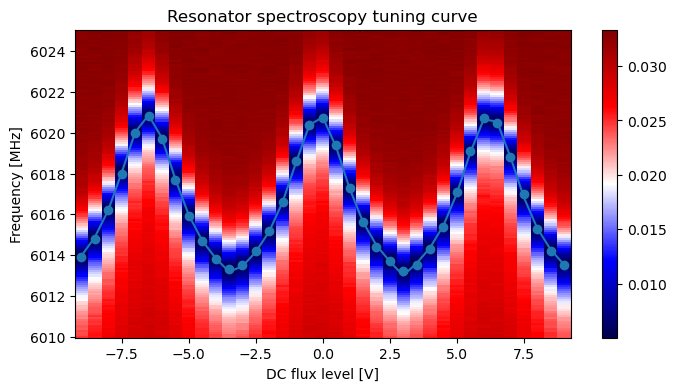

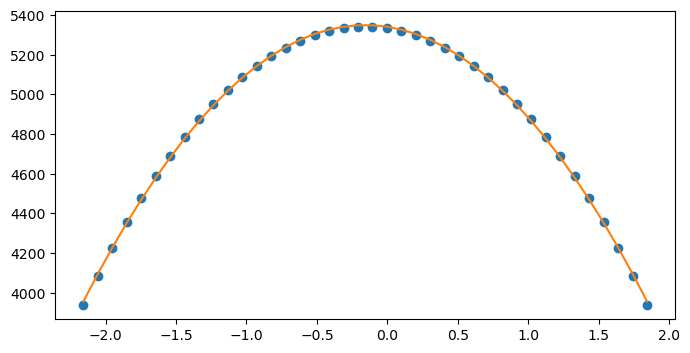

In [226]:
%matplotlib inline
ham_param = Analysis.exp2D.rr_vs_dc_flux(res_freq_sweep, dc_flux_sweep, sig_amp, init_guess = [6021, 170, 31E3, 0.05, 0.4, 80])
poly_param = Analysis.exp2D.qubit_vs_dc_flux_guess(ham_param)

In [227]:
# save the fitting parameters
machine.resonators[res_index].tuning_curve = ham_param.tolist()
machine.qubits[qubit_index].DC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)

In [228]:
# save the sweep spot flux according to fitted parameter
machine.flux_lines[flux_index].max_frequency_point = Analysis.get_sweept_spot(machine.qubits[qubit_index].DC_tuning_curve)
machine = Analysis.set_machine(machine)

## 1D qubit spectroscopy @ sweep spot

In [229]:
# set to sweet spot
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 5.67s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 5.72s
resonator frequency: 6020.920 MHz


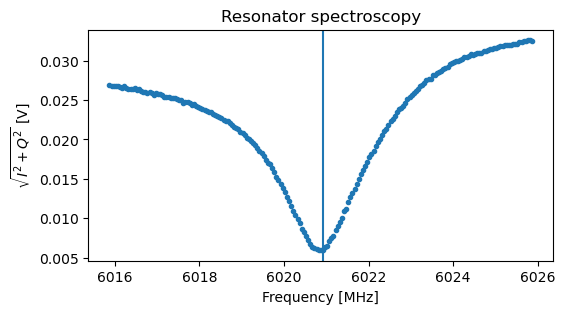

In [230]:
# calibrate RO
%matplotlib qt
#res_freq_sweep = np.arange(7.2575E9,7.2675E9 + 1.0,0.03E6)
ham_param = machine.resonators[res_index].tuning_curve
res_freq_est = Analysis.exp2D.ham([machine.flux_lines[flux_index].max_frequency_point], ham_param[0], ham_param[1], ham_param[2], ham_param[3], ham_param[4], ham_param[5], output_flag = 1) * 1E6 # to Hz
res_freq_sweep = int(res_freq_est[0]) + np.arange(-5E6, 5E6 + 1, 0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                       n_avg = 5E3, cd_time = 5E3, plot_flag = False, simulate_flag = False, simulation_len = 1000)
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
res_freq = int(res_freq.tolist())
machine.resonators[res_index].f_readout = res_freq + 0E6
machine.resonators[res_index].lo = res_freq + 50E6
machine = Analysis.set_machine(machine)

In [73]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index)

2024-02-13 08:56:04,507 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-13 08:56:04,516 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r6 for (LO, IF) = (6.071 GHz, -50.000 MHz)
2024-02-13 08:56:11,842 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q6 for (LO, IF) = (4.124 GHz, 200.000 MHz)
2024-02-13 08:56:24,414 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [66]:
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[0] + 0E6
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50E6
machine = Analysis.set_machine(machine)
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine,calibration_flag=True)

2024-03-21 11:46:59,629 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-21 11:46:59,638 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r6 for (LO, IF) = (6.071 GHz, -50.000 MHz)
2024-03-21 11:47:07,894 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q6 for (LO, IF) = (5.442 GHz, -50.000 MHz)
2024-03-21 11:47:22,101 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [74]:
if True: # for the DC flux
    qubit_freq_est = np.polyval(machine.qubits[qubit_index].DC_tuning_curve,machine.flux_lines[flux_index].max_frequency_point) * 1E6 # in Hz
else: # for the fast flux
    qubit_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,0.0) * 1E6 # in Hz
    
# After a run using the tuning curve data has been already done (uncomment top line otherwise)
# qubit_freq_sweep = int(qubit_freq_est) + np.arange(-60E6, 60E6 + 1, 1E6)
qubit_freq_sweep = int(machine.qubits[qubit_index].f_01) + np.arange(-150E6, 150E6 + 1, 1E6)

    
%matplotlib qt
machine, qubit_freq_sweep, sig_amp = Experiment.exp1D.Rabi.qubit_freq(qubit_freq_sweep, qubit_index, res_index, flux_index, 
                                      pi_amp_rel = 1, ff_amp = 0.0, n_avg = 5E3, cd_time = 25E3, plot_flag = False, 
                                      simulate_flag = False, simulation_len = 4000)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 39.39s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 39.44s


resonant frequency: 5414.512 MHz


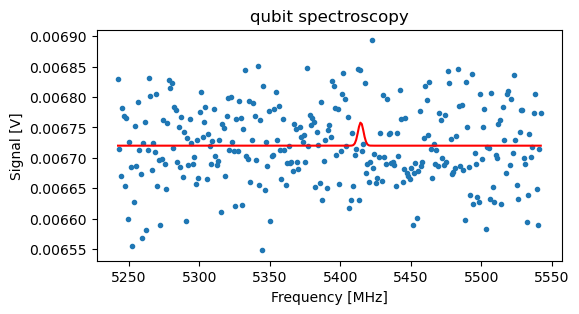

In [75]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=qubit_freq_sweep,y=sig_amp,method="gaussian")
# qubit_freq = int(qubit_freq.tolist())
# machine.qubits[qubit_index].f_01 = qubit_freq + 0E6
# machine.qubits[qubit_index].f_tls[0] = qubit_freq + 0E6
# machine.qubits[qubit_index].lo = qubit_freq + 50E6
# machine = Analysis.set_machine(machine)

In [10]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine)

2024-03-21 09:21:44,938 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-21 09:21:44,950 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r6 for (LO, IF) = (6.071 GHz, -50.000 MHz)
2024-03-21 09:21:52,275 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q6 for (LO, IF) = (5.440 GHz, -50.000 MHz)
2024-03-21 09:22:05,147 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## Rabi

### time rabi

In [33]:
%matplotlib qt
rabi_duration_sweep = np.arange(8, 45 + 0.1, 1)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1, n_avg = 10E3, cd_time = 25E3, plot_flag = False, machine = machine, simulate_flag = False, simulation_len = 10_000)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 9.68s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 9.73s


rabi_pi_pulse: 101.0 ns
half period: 95.81 ns


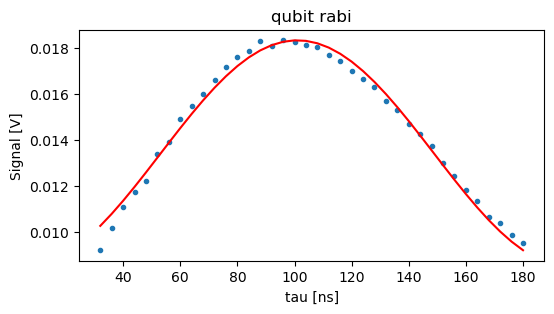

In [34]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,plot_flag = True)

In [31]:
machine.qubits[qubit_index].pi_length[0] = 100
#machine.qubits[qubit_index].pi_amp[0] = 0.02
machine = Analysis.set_machine(machine)

### power rabi

In [27]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.2, 2, 0.02) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, 
                                          n_avg = 10E3, cd_time = 25E3, plot_flag = False, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 23.31s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 23.36s


rabi_pi_pulse_amp: 0.16838 V
half period: 0.1662129 V


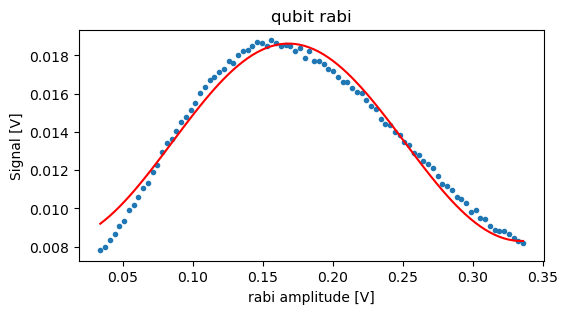

In [28]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [32]:
# machine.qubits[qubit_index].pi_amp[0] = pi_pulse_amp.item()
machine.qubits[qubit_index].pi_amp[0] = 0.155
machine = Analysis.set_machine(machine)

## T1

In [41]:
%matplotlib qt
tau_sweep_abs = np.arange(100,50E3+1,500)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.qubit_T1(tau_sweep_abs, qubit_index, res_index, flux_index, 
                   n_avg = 5E3, cd_time = 100E3, simulate_flag = False, simulation_len = 15_000, plot_flag = False)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 62.67s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 62.72s


Qubit T1 [us]: 8.255482515671302


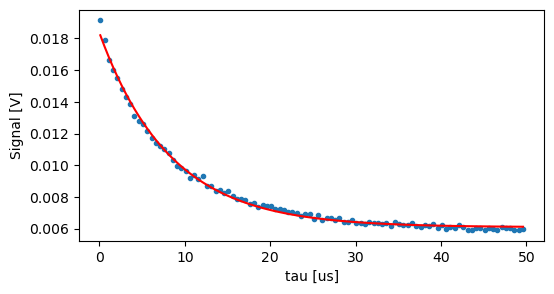

In [42]:
%matplotlib inline
q_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp")
machine.qubits[qubit_index].T1 = int(q_T1.tolist())
machine = Analysis.set_machine(machine)

## Ramsey

In [45]:
%matplotlib qt
ramsey_duration_sweep = np.arange(4, 100 + 0.1, 1)  # in units of clock cyles
machine, ramsey_duration_sweep, sig_amp = Experiment.exp1D.Ramsey.ramsey(ramsey_duration_sweep, qubit_index, res_index, flux_index, 
          n_avg = 10E3, detuning = 10E6, cd_time = 50E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 49.29s


Qubit T2* [ns]: 53.19999984536967
Detuning [MHz]: 11.387794073980245
Exponent n: 0.7878395547468363


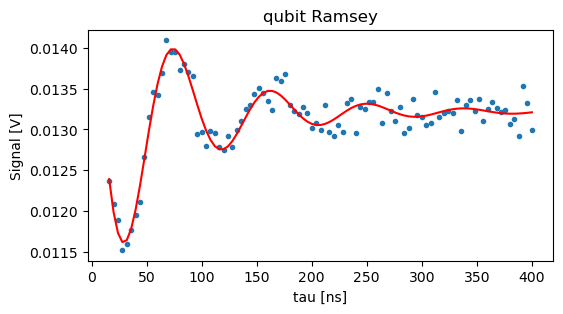

In [47]:
%matplotlib inline
q_T2star = Analysis.exp1D.ramsey(ramsey_duration_sweep, sig_amp,plot_flag = True)
machine.qubits[qubit_index].T2 = int(q_T2star.tolist())
machine = Analysis.set_machine(machine)

## ef transition

### ef frequency

In [ ]:
%matplotlib qt
ef_freq_sweep = machine.qubits[qubit_index].f_01 + np.arange(-200E6, -150E6 + 1, 0.5E6) 
machine, ef_freq_sweep, sig_amp = Experiment.exp1D.Rabi.ef_freq(ef_freq_sweep, qubit_index, res_index, flux_index, 
                      pi_amp_rel = 1, pi_amp_rel_ef = 1.0, n_avg = 2E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, 
                      simulate_flag = False, simulation_len = 4000)

In [ ]:
%matplotlib inline
ef_freq = Analysis.exp1D.peak_fit(x=ef_freq_sweep,y=sig_amp,method="gaussian")

In [ ]:
machine.qubits[qubit_index].anharmonicity = machine.qubits[qubit_index].f_01 - int(ef_freq)
machine = Analysis.set_machine(machine)

### ef transition time Rabi

In [ ]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 80 + 0.1, 1)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.ef_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1.0, pi_amp_rel_ef = 1.0,  n_avg = 2E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, machine = machine, simulate_flag = False, simulation_len = 10_000)

In [ ]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,plot_flag = True)

In [ ]:
machine.qubits[qubit_index].pi_length[1] = 80
machine = Analysis.set_machine(machine)

### ef transition power Rabi

In [ ]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.2, 3.0, 0.05) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.ef_rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, 
                          pi_amp_rel = 1.0, n_avg = 10E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, machine = machine,
                          simulate_flag = False, simulation_len = 1000)

In [ ]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [ ]:
machine.qubits[qubit_index].pi_amp[1] = pi_pulse_amp
machine = Analysis.set_machine(machine)

## 2D qubit spectroscopy vs dc flux

In [76]:
machine = Analysis.get_machine()

Progress: [##################################################] 100.0% (n=55/55) --> elapsed time: 1343.14s


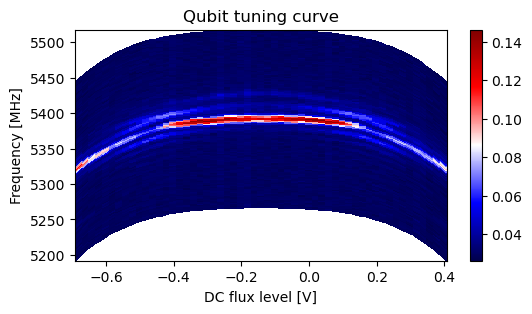

In [77]:
# try the experiment
%matplotlib inline
dc_flux_sweep = machine.flux_lines[flux_index].max_frequency_point + np.arange(-0.54,0.54+1E-4,0.02)
_,qubit_freq_sweep,dc_flux_sweep,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_dc_flux(dc_flux_sweep,qubit_index,res_index,flux_index,
                                 n_avg = 1E3, cd_time = 50E3, pi_amp_rel = 1.0, plot_flag = True)

In [78]:
# udpate the sweet spot
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_dc_flux(qubit_freq_sweep, dc_flux_sweep, sig_amp_qubit, fit_order = 2, plot_flag = False)
machine.flux_lines[flux_index].max_frequency_point = Analysis.get_sweept_spot(poly_param).tolist() + 0E1
print(f"sweet spot flux: {machine.flux_lines[flux_index].max_frequency_point:.5f} V")

sweet spot flux: -0.14232 V


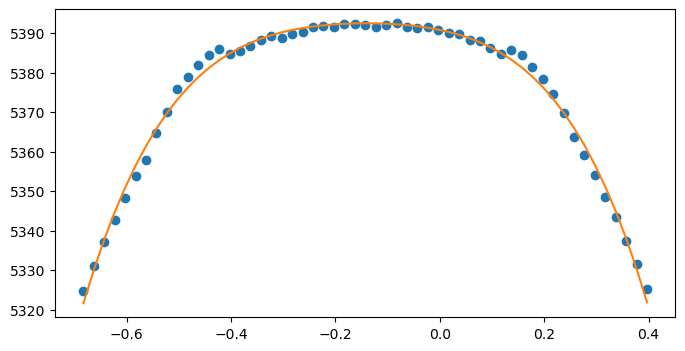

In [79]:
# save the sweep spot flux according to fitted parameter
poly_param = Analysis.exp2D.qubit_vs_dc_flux(qubit_freq_sweep, dc_flux_sweep, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].DC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

## 2D qubit spectroscopy vs fast flux

In [80]:
# set DC voltage to sweet spot, after possible dc flux sweep
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)
machine = Analysis.set_machine(machine)

### slow version, compiling 1D scans

In [81]:
# octave calibration
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True)

2024-03-21 12:22:34,077 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-21 12:22:34,088 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r6 for (LO, IF) = (6.071 GHz, -50.000 MHz)
2024-03-21 12:22:41,924 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q6 for (LO, IF) = (5.442 GHz, -50.000 MHz)
2024-03-21 12:22:56,390 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [91]:
# try the experiment
%matplotlib qt
#ff_sweep = np.arange(-0.02,-0.28-1E-4,-0.02)
ff_sweep = np.arange(0,0.28+1E-4,0.02)
qubit_if_sweep = np.arange(-60E6, 60E6 + 1, 1E6)
if False: # first time running this, no AC_tuning_curve
    machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux_slow(ff_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index,ff_to_dc_ratio = 5, machine = machine, n_avg = 1E3, cd_time = 50E3, pi_amp_rel = 1.0, plot_flag = True)
else: # after the first run 
    machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux_slow(ff_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index,ff_to_dc_ratio = None, machine = machine, n_avg = 1E3, cd_time = 50E3, pi_amp_rel = 1.0, plot_flag = True)

2024-03-21 12:46:33,296 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-21 12:46:33,309 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q6 for (LO, IF) = (5.104 GHz, 290.000 MHz)
2024-03-21 12:46:38,904 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


2024-03-21 12:48:18,057 - qm - INFO     - Performing health check.0% (n=9/15) --> elapsed time: 104.77s


INFO:qm.api.frontend_api:Performing health check


2024-03-21 12:48:18,068 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q6 for (LO, IF) = (4.901 GHz, 290.000 MHz)
2024-03-21 12:48:23,615 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


2024-03-21 12:49:11,392 - qm - INFO     - Performing health check.0% (n=12/15) --> elapsed time: 158.08s


INFO:qm.api.frontend_api:Performing health check


2024-03-21 12:49:11,404 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q6 for (LO, IF) = (4.676 GHz, 290.000 MHz)
2024-03-21 12:49:17,210 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


2024-03-21 12:49:56,133 - qm - INFO     - Performing health check.3% (n=14/15) --> elapsed time: 202.83s


INFO:qm.api.frontend_api:Performing health check


2024-03-21 12:49:56,145 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q6 for (LO, IF) = (4.454 GHz, 290.000 MHz)
2024-03-21 12:50:01,670 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=15/15) --> elapsed time: 237.45s


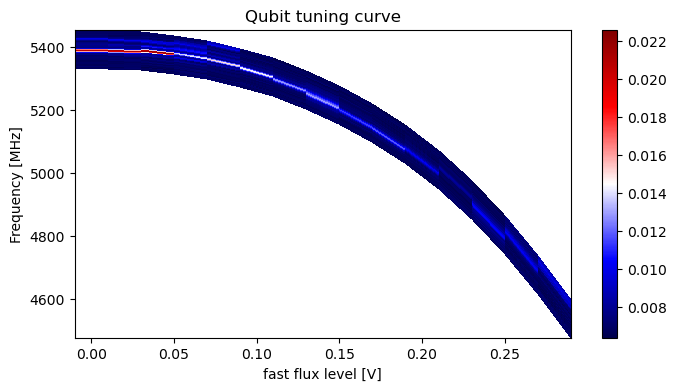

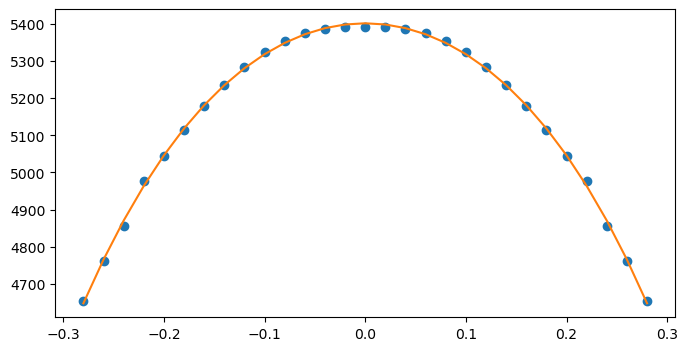

Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!


In [92]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_fast_flux(qubit_freq_sweep, ff_sweep_abs, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].AC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

### fast version, runs blockwise 2D sweeps

In [96]:
machine = Analysis.get_machine()

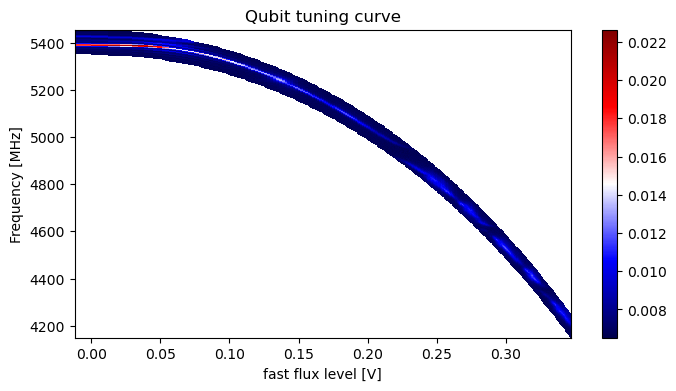

In [100]:
%matplotlib inline
fig = plt.figure()
plt.rcParams['figure.figsize'] = [8, 4]
plt.pcolormesh(ff_sweep_abs, (qubit_freq_sweep / u.MHz).T, sig_amp_qubit.T, cmap="seismic")
plt.title("Qubit tuning curve")
plt.xlabel("fast flux level [V]")
plt.ylabel("Frequency [MHz]")
plt.colorbar()

In [98]:
%matplotlib qt
q_freq_max = np.floor(np.polyval(machine.qubits[qubit_index].AC_tuning_curve, 0.0) * 1E6)
qubit_freq_sweep = np.arange(q_freq_max, 4.2E9, -5E6)
#qubit_freq_sweep = np.arange(q_freq_max,4E9,-100E6)
qubit_if_sweep = np.arange(-50E6, 50E6 + 1, 0.5E6)
machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux(qubit_freq_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index, n_avg = 5E3, cd_time = 50E3, plot_flag = True)

2024-03-21 13:53:09,074 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-21 13:53:09,085 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


2024-03-21 13:53:10,775 - qm - WARNING  - Open QM ended with warning 0: Opening a new Quantum Machine and closing Quantum Machines: 


2024-03-21 13:53:10,778 - qm - WARNING  - Open QM ended with warning 0: Quantum Machine qm-1711052227083 is canceling running job 1702933255009.


------------------------------------- Calibrates q6 for (LO, IF) = (5.102 GHz, 200.000 MHz)
2024-03-21 13:53:14,839 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 2060.20s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 2060.35s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 2060.14s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 2060.30s
2024-03-21 15:02:22,116 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-21 15:02:22,130 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q6 for (LO, IF) = (4.902 GHz, 200.000 MHz)
2024-03-21 15:02:27,842 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 2060.00s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 2060.16s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 2059.99s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 2060.16s
2024-03-21 16:11:35,771 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-21 16:11:35,786 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q6 for (LO, IF) = (4.302 GHz, 200.000 MHz)
2024-03-21 16:11:41,884 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 2060.05s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 2060.20s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 51.43s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 51.59s
2024-03-21 16:47:20,954 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-21 16:47:20,968 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q6 for (LO, IF) = (4.102 GHz, 200.000 MHz)
2024-03-21 16:47:26,597 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 2060.07s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 2060.23s
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!


<Figure size 800x400 with 0 Axes>

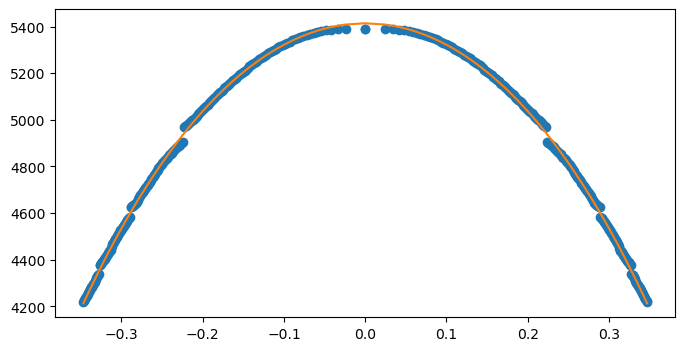

Execution stopped by user!


In [99]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_fast_flux(qubit_freq_sweep, ff_sweep_abs, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].AC_tuning_curve = poly_param.tolist()
#machine.qubits[qubit_index].AC_tuning_curve = [-4245.549395948013,0.0,-6707.594982241495,0.0,6413.009439410573]
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

# TLS experiments

## TLS SWAP spectroscopy

In [103]:
# got back to the SS
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[0] + 0E6
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50E6
machine = Analysis.set_machine(machine)
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine,calibration_flag=True)

2024-03-22 10:48:43,255 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-22 10:48:43,266 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r6 for (LO, IF) = (6.071 GHz, -50.000 MHz)
2024-03-22 10:48:50,848 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q6 for (LO, IF) = (5.442 GHz, -50.000 MHz)
2024-03-22 10:49:04,245 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [77]:
machine = Analysis.get_machine()
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True, machine = machine)

2024-03-13 16:09:25,870 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-13 16:09:25,882 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r6 for (LO, IF) = (6.071 GHz, -50.000 MHz)
2024-03-13 16:09:34,160 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q6 for (LO, IF) = (4.118 GHz, 200.000 MHz)
2024-03-13 16:09:47,954 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


### coarse, no baking

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 5690.06s


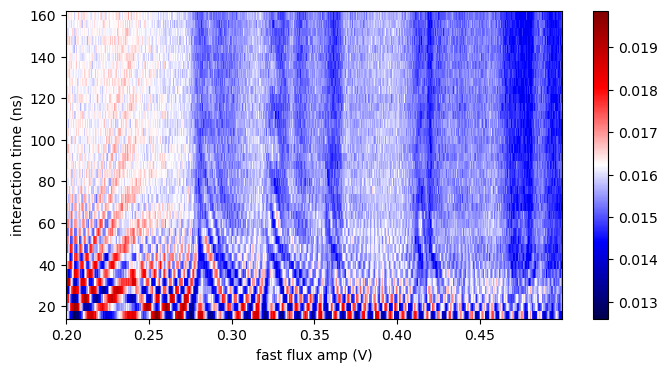

In [102]:
%matplotlib inline
tau_sweep_abs = np.arange(16,160 + 0.1,4)
ff_sweep_abs = np.arange(0.2,0.5,0.0005)
machine, ff_sweep_abs, tau_sweep_abs, sig_amp = Experiment.exp2D.SWAP.swap_coarse(tau_sweep_abs, ff_sweep_abs, qubit_index, res_index, flux_index, 
                      n_avg = 5E3, cd_time = 50E3, simulate_flag=False, simulation_len=10_000, plot_flag=True, machine = machine)

### fine, with baking

In [104]:
%matplotlib qt
tau_sweep_abs = np.arange(4,60,1)
ff_sweep_abs = np.arange(0.2,0.27+1E-4,0.0005)
machine, ff_sweep_abs, tau_sweep_abs, sig_amp = Experiment.exp2D.SWAP.swap_fine(tau_sweep_abs, ff_sweep_abs, qubit_index, res_index, flux_index, 
                      n_avg = 5E3, cd_time = 40E3, simulate_flag=False, simulation_len=10_000, plot_flag=True, machine = machine)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 3191.68s


In [105]:
machine.flux_lines[flux_index].iswap.length.append(8)
machine.flux_lines[flux_index].iswap.level.append(0.241)
machine = Analysis.set_machine(machine)

### estiguess of the TLS freq., based on SWAP flux

In [106]:
machine = Analysis.get_machine()

In [107]:
freq_tls = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[flux_index].iswap.level)
for f_tmp in freq_tls:
    machine.qubits[qubit_index].f_tls.append(np.floor(f_tmp*1E6))
machine = Analysis.set_machine(machine)

## TLS T1

In [108]:
print(freq_tls)

[4953.10459584 4859.52667879 4859.52667879]


In [109]:
TLS_index = 1

In [113]:
%matplotlib qt
tau_sweep_abs = np.arange(100,300E3+1,1E4)
# tau_sweep_abs = np.logspace(100,2000E3,50,endpoint=True)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.TLS_T1(tau_sweep_abs, qubit_index, res_index, flux_index, TLS_index,
                   n_avg = 4E3, cd_time_qubit = 40E3, cd_time_TLS =1000E3, simulate_flag = False, simulation_len = 15_000, plot_flag = True)

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 146.97s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 147.08s


Qubit T1 [us]: 10.850397966891547


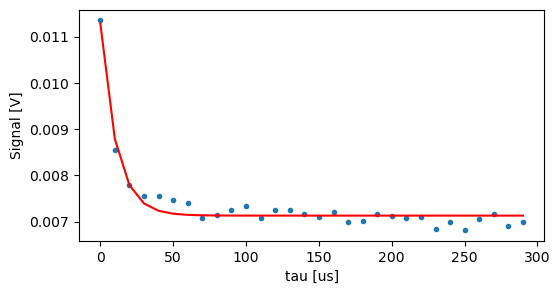

In [115]:
%matplotlib inline
TLS_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp")

## TLS drive

### TLS spectroscopy

In [177]:
# save the current qubit to the f_tls[0]
machine.qubits[qubit_index].f_tls[0] = machine.qubits[qubit_index].f_01

In [178]:
# TLS freq estimate based on SWAP flux amplitude
TLS_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[flux_index].iswap.level)
TLS_freq_est = np.round(TLS_freq_est[0] * 1E6)
if len(machine.qubits[qubit_index].f_tls) < TLS_index + 2: # need to increase size
    machine.qubits[qubit_index].f_tls.append(int(TLS_freq_est.tolist()) + 0E6)
    machine.qubits[qubit_index].lo.append(int(TLS_freq_est.tolist()) - 200E6)
else: # just update the value
    machine.qubits[qubit_index].f_tls[TLS_index+1] = (int(TLS_freq_est.tolist()))
    machine.qubits[qubit_index].lo = int(TLS_freq_est.tolist()) - 200E6

In [179]:
TLS_index = 0

In [180]:
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[TLS_index+1] + 0E6
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 - 200E6
machine = Analysis.set_machine(machine)

In [181]:
# calibrate octave for TLS sweep
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine = machine,calibration_flag = True)

2024-03-14 08:40:57,218 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-14 08:40:57,225 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r6 for (LO, IF) = (6.071 GHz, -50.000 MHz)
2024-03-14 08:41:05,313 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q6 for (LO, IF) = (4.754 GHz, 200.000 MHz)
2024-03-14 08:41:19,028 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [182]:
%matplotlib qt
TLS_freq_sweep = machine.qubits[qubit_index].f_tls[TLS_index+1] + np.arange(-100E6,100E6+1,0.5E6)
machine, TLS_freq_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_freq(TLS_freq_sweep, qubit_index, res_index, flux_index, TLS_index,
                  pi_amp_rel = 1.0, n_avg = 1E3, cd_time_qubit = 20E3, cd_time_TLS = 2000E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

KeyboardInterrupt: 

resonant frequency: 4980.982 MHz


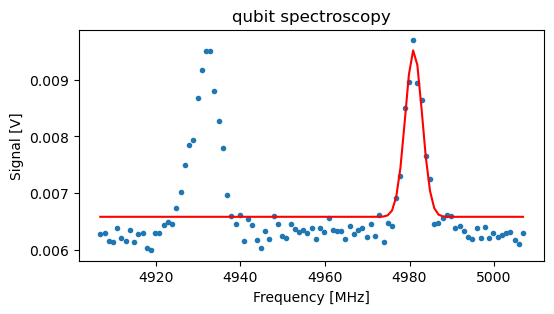

In [106]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=TLS_freq_sweep,y=sig_amp,method="gaussian")
qubit_freq = int(qubit_freq.tolist())
machine.qubits[qubit_index].f_tls[TLS_index+1] = qubit_freq + 0E6
machine.qubits[qubit_index].lo = qubit_freq - 250E6
machine = Analysis.set_machine(machine)

### TLS rabi

In [144]:
# # save the current qubit to the f_tls[0]
# machine.qubits[qubit_index].f_tls[0] = machine.qubits[qubit_index].f_01
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[TLS_index+1] +0E6

In [145]:
# calibrate octave 
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine = machine,calibration_flag = True)

4913671852.0

In [154]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 300 + 0.1, 4)  # in units of clock cyles
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, TLS_index,
                  pi_amp_rel = 1.0, n_avg = 10E3, cd_time_qubit = 20E3, cd_time_TLS = 20E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 30.65s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 30.74s
Execution stopped by user!
